<h1>SCA using neural networks</h1>

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, InputLayer, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


<h3>Load the data</h3>

In [15]:
filename = './extradatasets/ASCAD_desync50.h5'

In [16]:
def load_ascad(file_path):
    with h5py.File(file_path, 'r') as f:
        X_profiling = np.array(f['Profiling_traces/traces'])
        Y_profiling = np.array(f['Profiling_traces/labels'])
        X_attack = np.array(f['Attack_traces/traces'])
        Y_attack = np.array(f['Attack_traces/labels'])
        
        metadata_attack = f['Attack_traces/metadata']
        plaintexts_attack = np.array(metadata_attack['plaintext'])
        key = np.array(metadata_attack['key'])
    
    return (X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key

<h3>Visualize the data</h3>

Keys del archivo: ['Attack_traces', 'Profiling_traces']
Traces de entrenamiento: (50000, 700)
Etiquetas de entrenamiento: (50000,)
Traces de ataque: (10000, 700)
Etiquetas de ataque: (10000,)


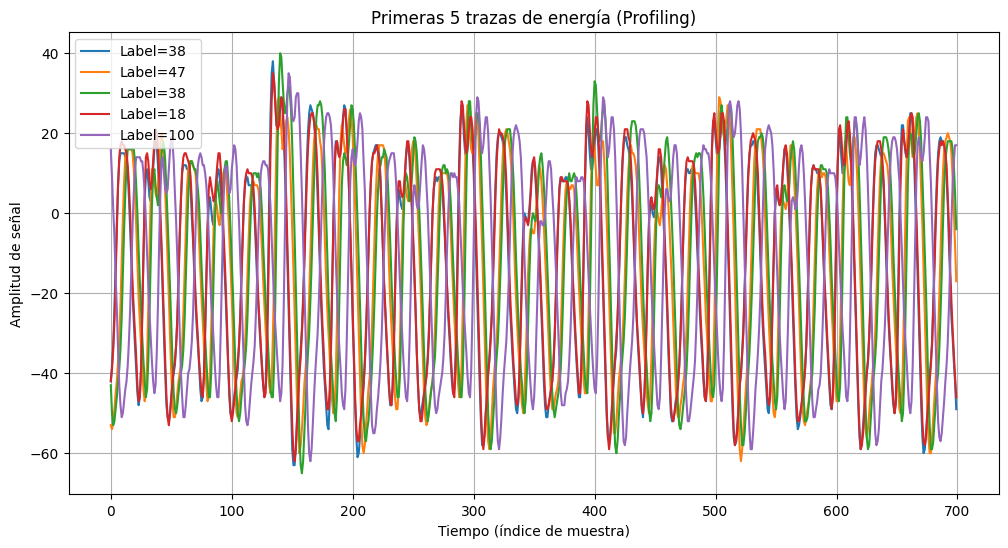

In [17]:
with h5py.File(filename, 'r') as f:
    print("Keys del archivo:", list(f.keys()))

    traces = f['Profiling_traces/traces']
    labels = f['Profiling_traces/labels']
    traces = np.array(traces[:])
    labels = np.array(labels[:])

    X_train = np.array(f['Profiling_traces/traces'])
    Y_train = np.array(f['Profiling_traces/labels'])
    X_val = np.array(f['Attack_traces/traces'])
    Y_val = np.array(f['Attack_traces/labels'])

    print("Traces de entrenamiento:", X_train.shape)
    print("Etiquetas de entrenamiento:", Y_train.shape)
    print("Traces de ataque:", X_val.shape)
    print("Etiquetas de ataque:", Y_val.shape)

num_traces_to_plot = 5

plt.figure(figsize=(12, 6))
for i in range(num_traces_to_plot):
    plt.plot(traces[i], label=f"Label={labels[i]}")

plt.title("Primeras 5 trazas de energía (Profiling)")
plt.xlabel("Tiempo (índice de muestra)")
plt.ylabel("Amplitud de señal")
plt.legend()
plt.grid(True)
plt.show()

<h3>Split data into trainig, validation and test</h3>

In [18]:
(X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key = load_ascad(filename)
X_train, X_val, Y_train, Y_val = train_test_split(X_profiling, Y_profiling, test_size=0.1, random_state=42)
print("Trazas de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", Y_train.shape)
print("Trazas de validación:", X_val.shape)
print("Etiquetas de validación:", Y_val.shape)
print("Trazas de ataque:", X_attack.shape)
print("Etiquetas de ataque:", Y_attack.shape)   

Trazas de entrenamiento: (45000, 700)
Etiquetas de entrenamiento: (45000,)
Trazas de validación: (5000, 700)
Etiquetas de validación: (5000,)
Trazas de ataque: (10000, 700)
Etiquetas de ataque: (10000,)


<h3>Preprocessing data</h3>

In [19]:
Y_profiling = to_categorical(Y_profiling, num_classes=256)
Y_train = to_categorical(Y_train, num_classes=256)
Y_val = to_categorical(Y_val, num_classes=256)
Y_attack = to_categorical(Y_attack, num_classes=256)

X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))

<h3>Build VGG16 based model</h3>

In [20]:
model = Sequential([
    InputLayer(shape=(X_profiling.shape[1], 1)),

    Conv1D(filters=64, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=128, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=256, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=512, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Conv1D(filters=512, kernel_size=11, activation='relu', padding='same'),
    AveragePooling1D(pool_size=2, strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),

    # output layer
    Dense(256, activation='softmax'),
])

optimizer = RMSprop(learning_rate=0.00001)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='models/best_model1.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 700, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 350, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 350, 128)       │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_6             │ (None, 175, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 175, 256)       │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_7             │ (None, 87, 256)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 87, 512)        │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_8             │ (None, 43, 512)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 43, 512)        │     2,884,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_9             │ (None, 21, 512)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    44,044,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,652,544 (254.26 MB)

 Trainable params: 66,652,544 (254.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, Y_train, epochs=75 , batch_size=200, validation_data=(X_val, Y_val), verbose=1, callbacks=[checkpoint])
model.save('models/ascad_model12.h5')

<h3>Evaluate model performance</h3>

In [ ]:
history = model.history.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
AES_SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def evaluate_model_success_and_entropy(model, X_attack, plaintexts, real_key_byte, byte_index=0, num_attacks=10, num_traces_per_attack=1000):
    all_ge_results = []
    all_sr_results = []

    for _ in range(num_attacks):
        indices = np.random.permutation(len(X_attack))[:num_traces_per_attack]
        X_subset = X_attack[indices]
        pt_subset = plaintexts[indices]

        predictions = model.predict(X_subset)
        key_guesses = np.zeros(256, dtype=np.float64)
        GE = []
        SR = []

        for trace_idx in range(num_traces_per_attack):
            pt_byte = pt_subset[trace_idx][byte_index]
            for kguess in range(256):
                sbox_out = AES_SBOX[pt_byte ^ kguess]
                key_guesses[kguess] += np.log(predictions[trace_idx][sbox_out] + 1e-36)

            sorted_guesses = np.argsort(key_guesses)[::-1]
            rank = list(sorted_guesses).index(real_key_byte)
            GE.append(rank)
            SR.append(1 if rank == 0 else 0)

            if rank == 0 and (len(GE) == 1 or GE[-2] != 0):
                print(f"Correct key first ranked at trace {trace_idx+1}")

        all_ge_results.append(GE)
        all_sr_results.append(SR)

    max_len = max(len(sr) for sr in all_sr_results)
    all_sr_padded = [sr + [sr[-1]] * (max_len - len(sr)) for sr in all_sr_results]

    ge_mean = np.mean(all_ge_results, axis=0)
    ge_std = np.std(all_ge_results, axis=0)
    sr_mean = np.mean(all_sr_padded, axis=0)

    return ge_mean, ge_std, sr_mean

def plot_guessing_entropy(ge_mean, ge_std=None, title="Guessing Entropy"):
    plt.figure(figsize=(10, 6))
    plt.plot(ge_mean, label='Mean rank')
    
    if ge_std is not None:
        plt.fill_between(range(len(ge_mean)), 
                        ge_mean - ge_std,
                        ge_mean + ge_std,
                        alpha=0.3)
    
    plt.grid(True)
    plt.xlabel('Number of traces')
    plt.ylabel('Rank of correct key')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

def plot_sr(sr_mean, title="Success Rate"):
    plt.figure(figsize=(10, 6))
    plt.plot(sr_mean, label='Mean Success Rate')
    plt.grid(True)
    plt.xlabel('Number of traces')
    plt.ylabel('Success Rate')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

def compute_guessing_entropy(predictions, plaintexts, real_key_byte, byte_index=0):
    num_traces = predictions.shape[0]
    key_guesses = np.zeros(256, dtype=np.float64)

    GE = []
    for trace_idx in range(num_traces):
        pt_byte = plaintexts[trace_idx][byte_index]
        for kguess in range(256):
            sbox_out = AES_SBOX[pt_byte ^ kguess]
            key_guesses[kguess] += np.log(predictions[trace_idx][sbox_out] + 1e-36)

        sorted_guesses = np.argsort(key_guesses)[::-1]
        rank = list(sorted_guesses).index(real_key_byte)
        GE.append(rank)

        if rank == 0:
            print(f"Correct key guessed at trace {trace_idx+1}")
            break
    
    return GE

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Correct key first ranked at trace 17
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Correct key first ranked at trace 75
Correct key first ranked at trace 79
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


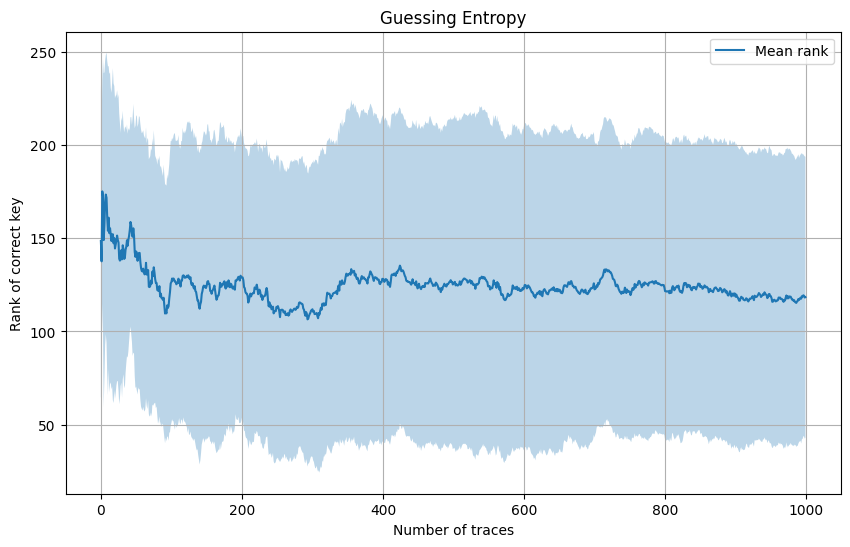

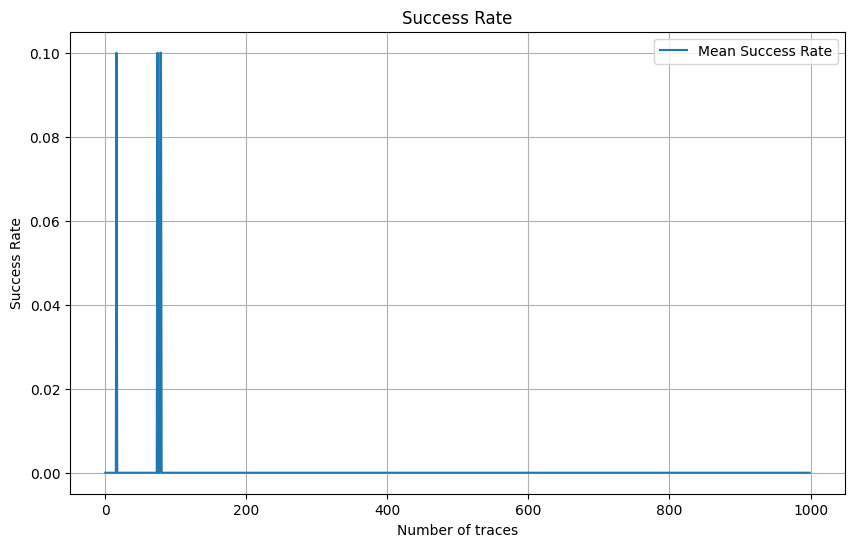

In [24]:
model = load_model('models/ascad_model10.h5')
ge_mean, ge_std, sr_mean = evaluate_model_success_and_entropy(
    model, X_attack, plaintexts_attack, real_key_byte=key[0][0], byte_index=0, num_attacks=10, num_traces_per_attack=1000
)
plot_guessing_entropy(ge_mean, ge_std)
plot_sr(sr_mean)